**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Production economy and CO2 taxation](#toc1_)    
- 2. [Problem 2: Career choice model](#toc2_)    
- 3. [Problem 3: Barycentric interpolation](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [94]:
#Packages used to solve the following Problems 1, 2 and 3:
import numpy as np
from types import SimpleNamespace
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from scipy.optimize import  root
import pandas as pd

## 1. <a id='toc1_'></a>[Problem 1: Production economy and CO2 taxation](#toc0_)

Consider a production economy with two firms indexed by $j \in \{1,2\}$. Each produce its own good. They solve

$$
\begin{align*}
\max_{y_{j}}\pi_{j}&=p_{j}y_{j}-w_{j}\ell_{j}\\\text{s.t.}\;&y_{j}=A\ell_{j}^{\gamma}.
\end{align*}
$$

Optimal firm behavior is

$$
\begin{align*}
\ell_{j}^{\star}(w,p_{j})&=\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}} \\
y_{j}^{\star}(w,p_{j})&=A\left(\ell_{j}^{\star}(w,p_{j})\right)^{\gamma}
\end{align*}
$$

The implied profits are

$$
\pi_{j}^*(w,p_{j})=\frac{1-\gamma}{\gamma}w\cdot\left(\frac{p_{j}A\gamma}{w}\right)^{\frac{1}{1-\gamma}}
$$

A single consumer supplies labor, and consumes the goods the firms produce. She also recieves the implied profits of the firm.<br>
She solves:

$$
\begin{align*}
U(p_1,p_2,w,\tau,T) = \max_{c_{1},c_{2},\ell} & \log(c_{1}^{\alpha}c_{2}^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} \\
\text{s.t.}\,\,\,&p_{1}c_{1}+(p_{2}+\tau)c_{2}=w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})
\end{align*}
$$

where $\tau$ is a tax and $T$ is lump-sum transfer. <br>
For a given $\ell$, it can be shown that optimal behavior is

$$
\begin{align*}
c_{1}(\ell)&=\alpha\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{1}} \\
c_{2}(\ell)&=(1-\alpha)\frac{w\ell+T+\pi_{1}^*(w,p_{1})+\pi_{2}^*(w,p_{2})}{p_{2}+\tau} \\
\end{align*}
$$
Such that optimal behavior is:
$$
\ell^* = \underset{\ell}{\arg\max} \log(\left(c_{1}(\ell)\right)^{\alpha}\cdot \left(c_{2}(\ell)\right)^{1-\alpha})-\nu\frac{\ell^{1+\epsilon}}{1+\epsilon} 
$$
With optimal consumption:
$$
\begin{align*}
c_1^*=c_{1}(\ell^*) \\
c_2^*=c_{2}(\ell^*)\\
\end{align*}
$$


The government chooses $\tau$ and balances its budget so $T=\tau c_2^*$. We initially set $\tau,T=0$.

Market clearing requires:

1. Labor market: $\ell^* = \ell_1^* + \ell_2^*$
1. Good market 1: $c_1^* = y_1^*$
1. Good market 2: $c_2^* = y_2^*$


**Question 1:** Check market clearing conditions for $p_1$ in `linspace(0.1,2.0,10)` and $p_2$ in `linspace(0.1,2.0,10)`. We choose $w=1$ as numeraire.

In [95]:
par = SimpleNamespace()

# firms
par.A = 1.0
par.gamma = 0.5

# households
par.alpha = 0.3
par.nu = 1.0
par.epsilon = 2.0

# government
par.tau = 0.0
par.T = 0.0

# Question 3
par.kappa = 0.1

# numeraire 
w = 1

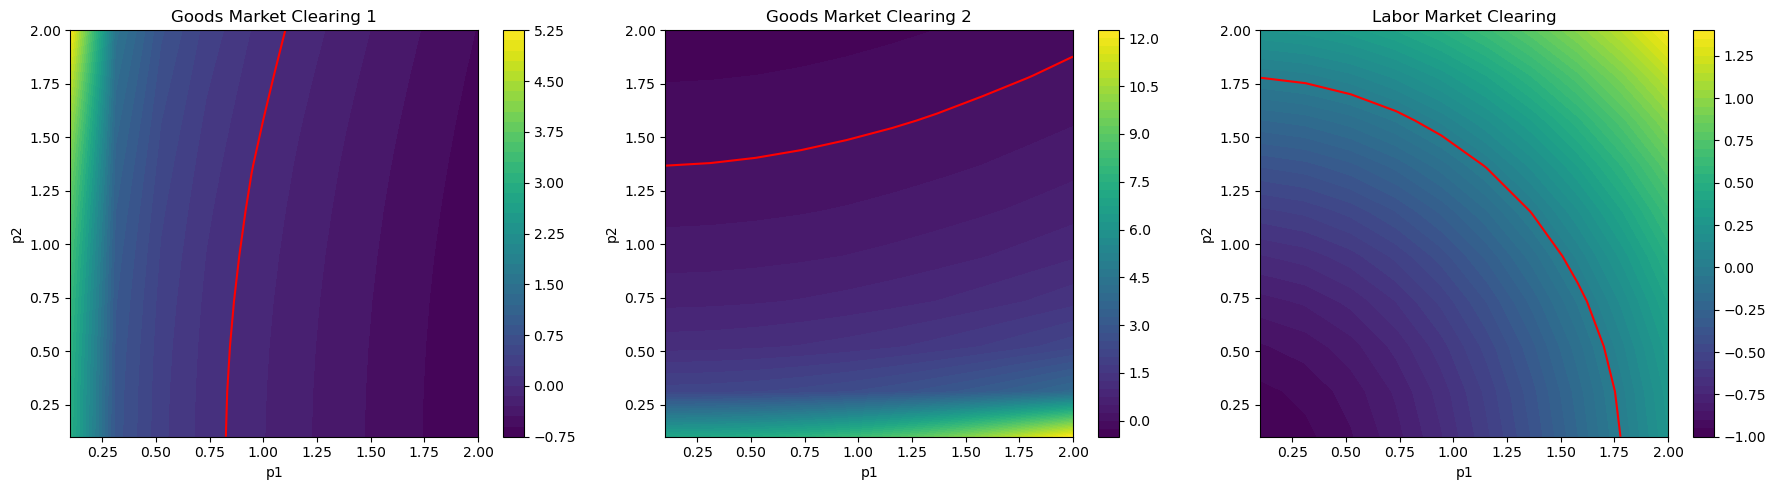

In [96]:
# Optimal firm behavior for firm 1 and 2
def optimal_firm_behavior1(w, p1, par):
    ell_star1 = ((p1 * par.A * par.gamma) / w) ** (1 / (1 - par.gamma))
    y_star1 = par.A * (ell_star1 ** par.gamma)
    pi1 = ((1-par.gamma)/par.gamma) * w * ((p1*par.A*par.gamma)/w)**(1/(1-par.gamma))
    return ell_star1, y_star1, pi1

def optimal_firm_behavior2(w, p2, par):
    ell_star2 = ((p2 * par.A * par.gamma) / w) ** (1 / (1 - par.gamma))
    y_star2 = par.A * (ell_star2 ** par.gamma)
    pi2 = ((1-par.gamma)/par.gamma) * w * ((p2*par.A*par.gamma)/w)**(1/(1-par.gamma))
    return ell_star2, y_star2, pi2
# Optimal behavior for consumers
def c1(w, ell, pi1, pi2, p1, par):
    return par.alpha * (w * ell + par.T + pi1 + pi2) / p1

def c2(w, ell, pi1, pi2, p2, par):
    return (1 - par.alpha) * (w * ell + par.T + pi1 + pi2) / (p2 + par.tau)

def optimal_behavior(w, pi1, pi2, p1, p2, par):
    def objective(ell):
        return - (np.log(c1(w, ell, pi1, pi2, p1, par)**par.alpha * c2(w, ell, pi1, pi2, p2, par)**(1-par.alpha)) - par.nu * ell**(1+par.epsilon) / (1+par.epsilon))
    
    result = minimize(objective, x0=1.0, bounds=[(0.1, 10.0)])
    ell_star = result.x[0]
    c1_star = c1(w, ell_star, pi1, pi2, p1, par)
    c2_star = c2(w, ell_star, pi1, pi2, p2, par)
    
    return ell_star, c1_star, c2_star
#calculating equilibrium
def evaluate_equilibrium(w, p1, p2, par):
    """ evaluate equilibrium """
    
    # a. optimal behavior of firms
    ell_star1, y_star1, pi1 = optimal_firm_behavior1(w, p1, par)
    ell_star2, y_star2, pi2 = optimal_firm_behavior2(w, p2, par)
    
    # b. optimal behavior of households
    ell_star, c1_star, c2_star = optimal_behavior(w, pi1, pi2, p1, p2, par)
    
    # d. market clearing
    goods_mkt_clearing1 = c1_star - y_star1
    goods_mkt_clearing2 = c2_star - y_star2
    labor_mkt_clearing = ell_star1 + ell_star2 - ell_star
    
    return goods_mkt_clearing1, goods_mkt_clearing2, labor_mkt_clearing
#setting up the grid
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)

goods_mkt_clearing1_values = np.zeros((len(p1_values), len(p2_values)))
goods_mkt_clearing2_values = np.zeros((len(p1_values), len(p2_values)))
labor_mkt_clearing_values = np.zeros((len(p1_values), len(p2_values)))
#finding the market clearings
for i, p1 in enumerate(p1_values):
    for j, p2 in enumerate(p2_values):
        goods_mkt_clearing1, goods_mkt_clearing2, labor_mkt_clearing = evaluate_equilibrium(w, p1, p2, par)
        goods_mkt_clearing1_values[i, j] = goods_mkt_clearing1
        goods_mkt_clearing2_values[i, j] = goods_mkt_clearing2
        labor_mkt_clearing_values[i, j] = labor_mkt_clearing

# Plotting the results
X, Y = np.meshgrid(p1_values, p2_values)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))

# Plot for goods market clearing 1
contour1 = ax[0].contourf(X, Y, goods_mkt_clearing1_values.T, levels=50, cmap='viridis')
zero_contour1 = ax[0].contour(X, Y, goods_mkt_clearing1_values.T, levels=[0], colors='red')
fig.colorbar(contour1, ax=ax[0])
ax[0].set_title('Goods Market Clearing 1')
ax[0].set_xlabel('p1')
ax[0].set_ylabel('p2')

# Plot for goods market clearing 2
contour2 = ax[1].contourf(X, Y, goods_mkt_clearing2_values.T, levels=50, cmap='viridis')
zero_contour2 = ax[1].contour(X, Y, goods_mkt_clearing2_values.T, levels=[0], colors='red')
fig.colorbar(contour2, ax=ax[1])
ax[1].set_title('Goods Market Clearing 2')
ax[1].set_xlabel('p1')
ax[1].set_ylabel('p2')

# Plot for labor market clearing
contour3 = ax[2].contourf(X, Y, labor_mkt_clearing_values.T, levels=50, cmap='viridis')
zero_contour3 = ax[2].contour(X, Y, labor_mkt_clearing_values.T, levels=[0], colors='red')
fig.colorbar(contour3, ax=ax[2])
ax[2].set_title('Labor Market Clearing')
ax[2].set_xlabel('p1')
ax[2].set_ylabel('p2')

plt.tight_layout()
plt.show()

The equilibrium prices, p1 and p2, for the three markets, are seen at the point of crossing for the three markets. The concrete values are shown further down.

In [97]:
# Setting up the grid for prices of good 1 and good 2
p1_values = np.linspace(0.1, 2.0, 10)
p2_values = np.linspace(0.1, 2.0, 10)

# Loop through each combination of p1 and p2 values to evaluate market clearing conditions
# Plotting the values which have a combined market clearing in the interval [-0.05, 0.05]
for p1 in p1_values:
    for p2 in p2_values:
        # Evaluate equilibrium conditions for given p1 and p2
        goods_mkt_clearing1, goods_mkt_clearing2, labor_mkt_clearing = evaluate_equilibrium(w, p1, p2, par)
        
        # Check if the sum of market clearing conditions is within the interval [-0.05, 0.05]
        if -0.05 < goods_mkt_clearing1 + goods_mkt_clearing2 + labor_mkt_clearing < 0.05:
            # Print the values of p1, p2 and the corresponding market clearing values
            print(f"p1: {p1}, p2: {p2}, Goods Market Clearing 1: {goods_mkt_clearing1}, Goods Market Clearing 2: {goods_mkt_clearing2}, Labor Market Clearing: {labor_mkt_clearing}")


p1: 0.7333333333333333, p2: 1.1555555555555557, Goods Market Clearing 1: 0.1790839736238639, Goods Market Clearing 2: 0.23035297803704602, Labor Market Clearing: -0.39751391083364246
p1: 0.7333333333333333, p2: 1.3666666666666667, Goods Market Clearing 1: 0.2207504854994971, Goods Market Clearing 2: 0.052132044175521974, Labor Market Clearing: -0.23313081640617817
p1: 0.9444444444444444, p2: 0.9444444444444444, Goods Market Clearing 1: -0.053794584907821685, Goods Market Clearing 2: 0.5041089315113791, Labor Market Clearing: -0.4252968829033599
p1: 0.9444444444444444, p2: 1.1555555555555557, Goods Market Clearing 1: -0.027034290696505037, Goods Market Clearing 2: 0.2712184377920993, Labor Market Clearing: -0.2878755869019489
p1: 0.9444444444444444, p2: 1.3666666666666667, Goods Market Clearing 1: 0.0058559500857112146, Goods Market Clearing 2: 0.08755152445317171, Labor Market Clearing: -0.12518436961139545
p1: 0.9444444444444444, p2: 1.577777777777778, Goods Market Clearing 1: 0.04518

**Question 2:** Find the equilibrium prices $p_1$ and $p_2$.<br>
*Hint: you can use Walras' law to only check 2 of the market clearings*

In [98]:
# Function to calculate market clearing conditions given prices p1 and p2
def market_clearing_conditions(params, w, par):
    p1, p2 = params  # Extract prices from parameters
    goods_mkt_clearing1, goods_mkt_clearing2, labor_mkt_clearing = evaluate_equilibrium(w, p1, p2, par)
    return [goods_mkt_clearing1, goods_mkt_clearing2]  # Return goods market clearing conditions

# Initial guess for p1 and p2 since they are close to market clearing prices
initial_guess = [1.0, 1.0]

# Find the root of the market clearing conditions
solution = root(market_clearing_conditions, initial_guess, args=(w, par))

# Check if the solution was found successfully
if solution.success:
    p1_star, p2_star = solution.x  # Extract equilibrium prices from solution
    print(f"Equilibrium prices found: p1 = {p1_star:.3f}, p2 = {p2_star:.3f}")
else:
    print("Failed to find equilibrium prices")

# Validate the equilibrium by evaluating market clearing conditions at the found prices
goods_mkt_clearing1, goods_mkt_clearing2, labor_mkt_clearing = evaluate_equilibrium(w, p1_star, p2_star, par)
print(f"Goods Market Clearing 1: {goods_mkt_clearing1:.3f}")
print(f"Goods Market Clearing 2: {goods_mkt_clearing2:.3f}")
print(f"Labor Market Clearing: {labor_mkt_clearing:.3f}")


Equilibrium prices found: p1 = 0.976, p2 = 1.491
Goods Market Clearing 1: -0.000
Goods Market Clearing 2: -0.000
Labor Market Clearing: 0.000


Here the prices are given, for all market being in equilibrium. 

Assume the government care about the social welfare function:

$$
SWF = U - \kappa y_2^*
$$

Here $\kappa$ measures the social cost of carbon emitted by the production of $y_2$ in equilibrium.

**Question 3:** What values of $\tau$ and (implied) $T$ should the government choose to maximize $SWF$?

In [99]:
# Optimal firm behavior for firm 1 and 2
def optimal_firm_behavior1(w, p1, par):
    ell_star1 = ((p1 * par.A * par.gamma) / w) ** (1 / (1 - par.gamma))
    y_star1 = par.A * (ell_star1 ** par.gamma)
    pi1 = ((1-par.gamma)/par.gamma) * w * ((p1*par.A*par.gamma)/w)**(1/(1-par.gamma))
    return ell_star1, y_star1, pi1

def optimal_firm_behavior2(w, p2, par):
    ell_star2 = ((p2 * par.A * par.gamma) / w) ** (1 / (1 - par.gamma))
    y_star2 = par.A * (ell_star2 ** par.gamma)
    pi2 = ((1-par.gamma)/par.gamma) * w * ((p2*par.A*par.gamma)/w)**(1/(1-par.gamma))
    return ell_star2, y_star2, pi2

# Household consumption functions
def c1(w, ell, pi1, pi2, p1, par):
    return par.alpha * (w * ell + par.T + pi1 + pi2) / p1

def c2(w, ell, pi1, pi2, p2, par):
    return (1 - par.alpha) * (w * ell + par.T + pi1 + pi2) / (p2 + par.tau)

# Optimal behavior of households
def optimal_behavior(w, pi1, pi2, p1, p2, par):
    def objective(ell):
        return - (np.log(c1(w, ell, pi1, pi2, p1, par)**par.alpha * c2(w, ell, pi1, pi2, p2, par)**(1-par.alpha)) - par.nu * ell**(1+par.epsilon) / (1+par.epsilon))
    
    result = minimize(objective, x0=1.0, bounds=[(0.1, 10.0)])
    ell_star = result.x[0]
    c1_star = c1(w, ell_star, pi1, pi2, p1, par)
    c2_star = c2(w, ell_star, pi1, pi2, p2, par)
    
    return ell_star, c1_star, c2_star

# Evaluate equilibrium
def evaluate_equilibrium(w, p1, p2, par):
    ell_star1, y_star1, pi1 = optimal_firm_behavior1(w, p1, par)
    ell_star2, y_star2, pi2 = optimal_firm_behavior2(w, p2, par)
    ell_star, c1_star, c2_star = optimal_behavior(w, pi1, pi2, p1, p2, par)
    goods_mkt_clearing1 = c1_star - y_star1
    goods_mkt_clearing2 = c2_star - y_star2
    labor_mkt_clearing = ell_star1 + ell_star2 - ell_star
    return goods_mkt_clearing1, goods_mkt_clearing2, labor_mkt_clearing, y_star2, c2_star

# Social Welfare Function
def social_welfare_function(tau, w, par, p1_star, p2_star):
    par.tau = tau
    ell_star1, y_star1, pi1 = optimal_firm_behavior1(w, p1_star, par)
    ell_star2, y_star2, pi2 = optimal_firm_behavior2(w, p2_star, par)
    ell_star, c1_star, c2_star = optimal_behavior(w, pi1, pi2, p1_star, p2_star, par)
    
    par.T = tau * c2_star  # Update T based on tau
    U = np.log(c1_star**par.alpha * c2_star**(1-par.alpha)) - par.nu * ell_star**(1+par.epsilon) / (1+par.epsilon)
    SWF = U - par.kappa * y_star2
    return -SWF  # minimize the negative of SWF to maximize SWF

# Initial guess for tau
initial_guess_tau = 0.5

# Equilibrium prices found
p1_star = 0.9759
p2_star = 1.4908

# Find the optimal tau
solution_tau = minimize(social_welfare_function, initial_guess_tau, args=(w, par, p1_star, p2_star), bounds=[(0.0, 1.0)])

if solution_tau.success:
    tau_star = solution_tau.x[0]
else:
    print("Failed to find optimal tau")

# Validate the SWF at the optimal tau
par.tau = tau_star
ell_star1, y_star1, pi1 = optimal_firm_behavior1(w, p1_star, par)
ell_star2, y_star2, pi2 = optimal_firm_behavior2(w, p2_star, par)
ell_star, c1_star, c2_star = optimal_behavior(w, pi1, pi2, p1_star, p2_star, par)
par.T = tau_star * c2_star

# Ensure par.T is a scalar
T_scalar = par.T.item() if isinstance(par.T, np.ndarray) else par.T
c2_scalar = c2_star.item() if isinstance(c2_star, np.ndarray) else c2_star

# Print the results
print(f"Optimal tau: {tau_star:.3f}")
print(f"Government transfer T: {T_scalar:.3f}")
print(f"Equilibrium consumption c2*: {c2_scalar:.3f}")

Optimal tau: 0.500
Government transfer T: 0.326
Equilibrium consumption c2*: 0.652


## 2. <a id='toc2_'></a>[Problem 2: Career choice model](#toc0_)

Consider a graduate $i$ making a choice between entering $J$ different career tracks. <br>
Entering career $j$ yields utility $u^k_{ij}$. This value is unknown to the graduate ex ante, but will ex post be: <br>
$$
    u_{i,j}^k = v_{j} + \epsilon_{i,j}^k
$$

They know that $\epsilon^k_{i,j}\sim \mathcal{N}(0,\sigma^2)$, but they do not observe $\epsilon^k_{i,j}$ before making their career choice. <br>

Consider the concrete case of $J=3$ with:
$$
\begin{align*}
    v_{1} &= 1 \\
    v_{2} &= 2 \\
    v_{3} &= 3
\end{align*}
$$

If the graduates know the values of $v_j$ and the distribution of $\epsilon_{i,j}^k$, they can calculate the expected utility of each career track using simulation: <br>
$$
    \mathbb{E}\left[ u^k_{i,j}\vert v_j \right] \approx v_j + \frac{1}{K}\sum_{k=1}^K \epsilon_{i,j}^k
$$

In [100]:
par = SimpleNamespace()
par.J = 3
par.N = 10
par.K = 10000
par.F = np.arange(1,par.N+1)
par.sigma = 2
par.v = np.array([1,2,3])
par.c = 1


**Question 1:** Simulate and calculate expected utility and the average realised utility for $K=10000$ draws, for each career choice $j$.


In [101]:
# Simulate e_ij^k ~ N(0, sigma^2)
e_ij = np.random.normal(0, par.sigma, (par.J, par.N, par.K))

# Calculate the average realised utility
average_realised_utility = np.mean(par.v[:, np.newaxis] + (1 / par.K) * np.sum(e_ij, axis=2), axis=1)

# Create a DataFrame to display the results with expected utility as v_j
df = pd.DataFrame({
    'Career Track': np.arange(1, par.J + 1),
    'Expected Utility': par.v,
    'Average Realised Utility': average_realised_utility
})

# Display the DataFrame
print(df)

   Career Track  Expected Utility  Average Realised Utility
0             1                 1                  1.000311
1             2                 2                  1.988942
2             3                 3                  3.002625


Now consider a new scenario: Imagine that the graduate does not know $v_j$. The *only* prior information they have on the value of each job, comes from their $F_{i}$ friends that work in each career $j$. After talking with them, they know the average utility of their friends (which includes their friends' noise term), giving them the prior expecation: <br>
$$
\tilde{u}^k_{i,j}\left( F_{i}\right) = \frac{1}{F_{i}}\sum_{f=1}^{F_{i}} \left(v_{j} + \epsilon^k_{f,j}\right), \; \epsilon^k_{f,j}\sim \mathcal{N}(0,\sigma^2)
$$
For ease of notation consider that each graduate have $F_{i}=i$ friends in each career. <br>

For $K$ times do the following: <br>
1. For each person $i$ draw $J\cdot F_i$ values of $\epsilon_{f,j}^{k}$, and calculate the prior expected utility of each career track, $\tilde{u}^k_{i,j}\left( F_{i}\right)$. <br>
Also draw their own $J$ noise terms, $\epsilon_{i,j}^k$
1. Each person $i$ chooses the career track with the highest expected utility: $$j_i^{k*}= \arg\max_{j\in{1,2\dots,J}}\left\{ \tilde{u}^k_{i,j}\left( F_{i}\right)\right\} $$
1. Store the chosen careers: $j_i^{k*}$, the prior expectation of the value of their chosen career: $\tilde{u}^k_{i,j=j_i^{k*}}\left( F_{i}\right)$, and the realized value of their chosen career track: $u^k_{i,j=j_i^{k*}}=v_{j=j_i^{k*}}+\epsilon_{i,j=j_i^{k*}}^k$.

Chosen values will be: <br>
$i\in\left\{1,2\dots,N\right\}, N=10$ <br>
$F_i = i$<br>
So there are 10 graduates. The first has 1 friend in each career, the second has 2 friends, ... the tenth has 10 friends.

**Question 2:** Simulate and visualize: For each type of graduate, $i$, the share of graduates choosing each career, the average subjective expected utility of the graduates, and the average ex post realized utility given their choice. <br>
That is, calculate and visualize: <br>
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \mathbb{I}\left\{ j=j_i^{k*} \right\}  \;\forall j\in\left\{1,2,\dots,J\right\}
\end{align*}
$$
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} \tilde{u}^k_{ij=j_i^{k*}}\left( F_{i}\right)
\end{align*}
$$
And 
$$
\begin{align*}
    \frac{1}{K} \sum_{k=1}^{K} u^k_{ij=j_i^{k*}} 
\end{align*}
$$
For each graduate $i$.

In [102]:
# Initialize results storage
career_choices = np.zeros((par.N, par.K), dtype=int)
prior_expectations = np.zeros((par.N, par.K))
realized_utilities = np.zeros((par.N, par.K))

# Step 1: Simulate the initial career choices and utilities
for i in range(par.N):
    Fi = i + 1
    # Calculate prior expected utility from friends
    friend_utilities = par.v + np.random.normal(0, par.sigma, (Fi, par.J))
    prior_exp_utility = friend_utilities.mean(axis=0)
    
    # Simulate own noise terms and calculate total expected utility
    own_noise = np.random.normal(0, par.sigma, (par.K, par.J))
    total_exp_utility = prior_exp_utility + own_noise
    
    # Choose the career track with the highest expected utility
    chosen_careers = np.argmax(total_exp_utility, axis=1)
    career_choices[i] = chosen_careers
    prior_expectations[i] = prior_exp_utility[chosen_careers]
    realized_utilities[i] = par.v[chosen_careers] + own_noise[np.arange(par.K), chosen_careers]

# Step 2: Calculate results for the initial career choices
career_share = np.zeros((par.N, par.J))
avg_subjective_utility = np.zeros(par.N)
avg_realized_utility = np.zeros(par.N)

for i in range(par.N):
    for j in range(par.J):
        career_share[i, j] = np.mean(career_choices[i] == j)
    avg_subjective_utility[i] = np.mean(prior_expectations[i])
    avg_realized_utility[i] = np.mean(realized_utilities[i])

# Prepare the data for the table
data = {
    "Graduate Index": np.arange(1, par.N + 1),
    "Career 1 Share (%)": career_share[:, 0] * 100,
    "Career 2 Share (%)": career_share[:, 1] * 100,
    "Career 3 Share (%)": career_share[:, 2] * 100,
    "Average Subjective Expected Utility": avg_subjective_utility,
    "Average Realized Utility": avg_realized_utility
}

# Create the DataFrame
results_df = pd.DataFrame(data)

# Display the DataFrame
results_df


,Graduate Index,Career 1 Share (%),Career 2 Share (%),Career 3 Share (%),Average Subjective Expected Utility,Average Realized Utility
0,1,21.39,4.46,74.15,4.184465,3.588908
1,2,0.32,83.61,16.07,4.290542,2.865146
2,3,24.62,42.04,33.34,1.557321,3.772886
3,4,37.05,44.30,18.65,1.600352,3.433527
4,5,1.50,21.94,76.56,4.264900,3.701249
5,6,30.76,16.18,53.06,2.532889,3.748941
6,7,27.26,26.11,46.63,1.998678,3.847777
7,8,12.93,28.63,58.44,2.127950,3.905590
8,9,12.58,37.05,50.37,2.358805,3.907308
9,10,9.41,31.99,58.60,2.891487,3.876686


After a year of working in their career, the graduates learn $u^k_{ij}$ for their chosen job $j_i^{k*}$ perfectly. <br>
The can switch to one of the two remaining careers, for which they have the same prior as before, but it will now include a switching cost of $c$ which is known.
Their new priors can be written as: 
$$
\tilde{u}^{k,2}_{ij}\left( F_{i}\right) = \begin{cases}
            \tilde{u}^k_{ij}\left( F_{i}\right)-c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

We will set $c=1$.

Their realized utility will be: <br>
$$
u^{k,2}_{ij}= \begin{cases}
            u_{ij}^k -c & \text{if } j \neq j_i^{k*} \\
            u_{ij=j_i^{k*}} & \text{if } j = j_i^{k*}
        \end{cases}
$$

**Question 3:** Following the same approach as in question 2, find the new optimal career choice for each $i$, $k$. Then for each $i$, calculate the average subjective expected utility from their new optimal career choice, and the ex post realized utility of that career. Also, for each $i$, calculate the share of graduates that chooses to switch careers, conditional on which career they chose in the first year. <br>

In [103]:
# Initialize results storage for switching careers
new_career_choices = np.zeros((par.N, par.K), dtype=int)
new_prior_expectations = np.zeros((par.N, par.K))
new_realized_utilities = np.zeros((par.N, par.K))

# Simulate for each graduate switching careers
for i in range(par.N):
    Fi = i + 1
    # Calculate prior expected utility from friends
    friend_utilities = par.v + np.random.normal(0, par.sigma, (Fi, par.J))
    prior_exp_utility = friend_utilities.mean(axis=0)
    
    # Simulate own noise terms and calculate total expected utility
    own_noise = np.random.normal(0, par.sigma, (par.K, par.J))
    total_exp_utility = prior_exp_utility + own_noise
    
    # Choose the career track with the highest expected utility initially
    chosen_careers = np.argmax(total_exp_utility, axis=1)
    
    # After learning the true utility of their chosen job, simulate switching
    for k in range(par.K):
        current_career = chosen_careers[k]
        current_realized_utility = par.v[current_career] + own_noise[k, current_career]
        
        # Calculate new priors for the remaining two careers
        new_priors = prior_exp_utility.copy()
        new_priors[current_career] = current_realized_utility
        
        # Apply switching cost to other careers
        new_priors = np.where(np.arange(par.J) != current_career, new_priors - par.c, new_priors)
        
        # Choose the new optimal career
        new_career = np.argmax(new_priors)
        new_career_choices[i, k] = new_career
        new_prior_expectations[i, k] = new_priors[new_career]
        new_realized_utilities[i, k] = par.v[new_career] + own_noise[k, new_career]

# Step 2: Calculate results for the new career choices after switching
new_career_share = np.zeros((par.N, par.J))
new_avg_subjective_utility = np.zeros(par.N)
new_avg_realized_utility = np.zeros(par.N)
switching_rate = np.zeros(par.N)

for i in range(par.N):
    for j in range(par.J):
        new_career_share[i, j] = np.mean(new_career_choices[i] == j)
    new_avg_subjective_utility[i] = np.mean(new_prior_expectations[i])
    new_avg_realized_utility[i] = np.mean(new_realized_utilities[i])
    switching_rate[i] = np.mean(new_career_choices[i] != career_choices[i])

# Prepare the data for the table
switching_data = {
    "Graduate Index": np.arange(1, par.N + 1),
    "New Career 1 Share (%)": new_career_share[:, 0] * 100, #To show percentage-value
    "New Career 2 Share (%)": new_career_share[:, 1] * 100, #To show percentage-value
    "New Career 3 Share (%)": new_career_share[:, 2] * 100, #To show percentage-value
    "New Average Subjective Expected Utility": new_avg_subjective_utility,
    "New Average Realized Utility": new_avg_realized_utility,
    "Switching Rate (%)": switching_rate * 100 #To show percentage-value
}

# Create the DataFrame
switching_results_df = pd.DataFrame(switching_data)

# Display the DataFrame
switching_results_df


,Graduate Index,New Career 1 Share (%),New Career 2 Share (%),New Career 3 Share (%),New Average Subjective Expected Utility,New Average Realized Utility,Switching Rate (%)
0,1,16.90,0.46,82.64,3.789278,2.972229,35.15
1,2,15.23,10.38,74.39,4.071417,3.375787,79.23
2,3,10.94,25.18,63.88,4.057152,3.717962,65.69
3,4,12.26,12.68,75.06,3.824874,3.648481,75.83
4,5,9.00,10.41,80.59,3.764849,3.563629,35.88
5,6,18.31,25.32,56.37,3.918400,3.869855,60.22
6,7,10.47,22.67,66.86,3.908083,3.809629,59.89
7,8,4.32,18.67,77.01,3.736468,3.641574,49.61
8,9,20.33,24.80,54.87,3.911411,3.854596,60.12
9,10,7.91,17.32,74.77,3.817057,3.716334,50.70


## 3. <a id='toc3_'></a>[Problem 3: Barycentric interpolation](#toc0_)

**Problem:** We have a set of random points in the unit square,

$$
\mathcal{X} = \{(x_1,x_2)\,|\,x_1\sim\mathcal{U}(0,1),x_2\sim\mathcal{U}(0,1)\}.
$$

For these points, we know the value of some function $f(x_1,x_2)$,

$$
\mathcal{F} = \{f(x_1,x_2) \,|\, (x_1,x_2) \in \mathcal{X}\}.
$$

Now we want to approximate the value $f(y_1,y_2)$ for some  $y=(y_1,y_2)$, where $y_1\sim\mathcal{U}(0,1)$ and $y_2\sim\mathcal{U}(0,1)$.

**Building block I**

For an arbitrary triangle $ABC$ and a point $y$, define the so-called barycentric coordinates as:

$$
\begin{align*}
  r^{ABC}_1 &= \frac{(B_2-C_2)(y_1-C_1) + (C_1-B_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_2 &= \frac{(C_2-A_2)(y_1-C_1) + (A_1-C_1)(y_2-C_2)}{(B_2-C_2)(A_1-C_1) + (C_1-B_1)(A_2-C_2)} \\
  r^{ABC}_3 &= 1 - r_1 - r_2.
\end{align*}
$$

If $r^{ABC}_1 \in [0,1]$, $r^{ABC}_2 \in [0,1]$, and $r^{ABC}_3 \in [0,1]$, then the point is inside the triangle.

We always have $y = r^{ABC}_1 A + r^{ABC}_2 B + r^{ABC}_3 C$.

**Building block II**

Define the following points:

$$
\begin{align*}
A&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}>y_{2}\\
B&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}>y_{1}\text{ and }x_{2}<y_{2}\\
C&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}<y_{2}\\
D&=\arg\min_{(x_{1},x_{2})\in\mathcal{X}}\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2}}\text{ s.t. }x_{1}<y_{1}\text{ and }x_{2}>y_{2}.
\end{align*}
$$

**Algorithm:**

1. Compute $A$, $B$, $C$, and $D$. If not possible return `NaN`.
1. If $y$ is inside the triangle $ABC$ return $r^{ABC}_1 f(A) + r^{ABC}_2 f(B) + r^{ABC}_3 f(C)$.
1. If $y$ is inside the triangle $CDA$ return $r^{CDA}_1 f(C) + r^{CDA}_2 f(D) + r^{CDA}_3 f(A)$.
1. Return `NaN`.



**Sample:**

In [104]:
rng = np.random.default_rng(2024)

X = rng.uniform(size=(50,2))
y = rng.uniform(size=(2,))


**Questions 1:** Find $A$, $B$, $C$ and $D$. Illustrate these together with $X$, $y$ and the triangles $ABC$ and $CDA$.

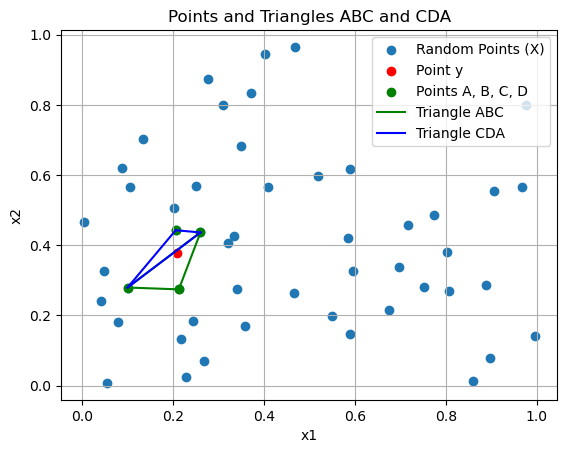

Point y: (0.209, 0.378)
Point A: (0.261, 0.436)
Point B: (0.213, 0.274)
Point C: (0.101, 0.280)
Point D: (0.206, 0.443)


In [105]:
# Redefine the functions provided earlier
def barycentric_coordinates(A, B, C, g):
    r1_ABC = ((B[1] - C[1]) * (g[0] - C[0]) + (C[0] - B[0]) * (g[1] - C[1])) / ((B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1]))
    r2_ABC = ((C[1] - A[1]) * (g[0] - C[0]) + (A[0] - C[0]) * (g[1] - C[1])) / ((B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1]))
    r3_ABC = 1 - r1_ABC - r2_ABC
    return r1_ABC, r2_ABC, r3_ABC

# Function to check if the point is inside the triangle
def is_inside_triangle(r1, r2, r3):
    return 0 <= r1 <= 1 and 0 <= r2 <= 1 and 0 <= r3 <= 1

def find_closest_points(X, y):
    A = min([(x_i, y_i) for x_i, y_i in X if x_i > y[0] and y_i > y[1]], key=lambda p: np.sqrt((p[0] - y[0])**2 + (p[1] - y[1])**2), default=None)
    B = min([(x_i, y_i) for x_i, y_i in X if x_i > y[0] and y_i < y[1]], key=lambda p: np.sqrt((p[0] - y[0])**2 + (p[1] - y[1])**2), default=None)
    C = min([(x_i, y_i) for x_i, y_i in X if x_i < y[0] and y_i < y[1]], key=lambda p: np.sqrt((p[0] - y[0])**2 + (p[1] - y[1])**2), default=None)
    D = min([(x_i, y_i) for x_i, y_i in X if x_i < y[0] and y_i > y[1]], key=lambda p: np.sqrt((p[0] - y[0])**2 + (p[1] - y[1])**2), default=None)
    return A, B, C, D

# Find the points A, B, C, D around point y
A, B, C, D = find_closest_points(X, y)

# Plotting the points and the triangles
plt.scatter(X[:, 0], X[:, 1], label='Random Points (X)')
plt.scatter([y[0]], [y[1]], color='red', label='Point y')
plt.scatter([A[0], B[0], C[0], D[0]], [A[1], B[1], C[1], D[1]], color='green', label='Points A, B, C, D')

# Plot triangle ABC if points A, B, and C are found
if A and B and C:
    plt.plot([A[0], B[0]], [A[1], B[1]], 'g-')
    plt.plot([B[0], C[0]], [B[1], C[1]], 'g-')
    plt.plot([C[0], A[0]], [C[1], A[1]], 'g-', label='Triangle ABC')

if C and D and A:
    plt.plot([C[0], D[0]], [C[1], D[1]], 'b-')
    plt.plot([D[0], A[0]], [D[1], A[1]], 'b-')
    plt.plot([A[0], C[0]], [A[1], C[1]], 'b-', label='Triangle CDA')

plt.legend()
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Points and Triangles ABC and CDA')
plt.grid(True)
plt.show()

# Printing the points y, A, B, C, and D for x1 and x2
print("Point y: ({:.3f}, {:.3f})".format(y[0], y[1]))
print("Point A: ({:.3f}, {:.3f})".format(A[0], A[1]))
print("Point B: ({:.3f}, {:.3f})".format(B[0], B[1]))
print("Point C: ({:.3f}, {:.3f})".format(C[0], C[1]))
print("Point D: ({:.3f}, {:.3f})".format(D[0], D[1]))



**Question 2:** Compute the barycentric coordinates of the point $y$ with respect to the triangles $ABC$ and $CDA$. Which triangle is $y$ located inside?

In [106]:
# Compute barycentric coordinates for triangle ABC
r1_ABC, r2_ABC, r3_ABC = barycentric_coordinates(A, B, C, y)

# Compute barycentric coordinates for triangle CDA
r1_CDA, r2_CDA, r3_CDA = barycentric_coordinates(C, D, A, y)

# Check which triangle y is inside
inside_ABC = is_inside_triangle(r1_ABC, r2_ABC, r3_ABC)
inside_CDA = is_inside_triangle(r1_CDA, r2_CDA, r3_CDA)

# Print the results
print("Barycentric coordinates with respect to triangle ABC: r1 = {:.3f}, r2 = {:.3f}, r3 = {:.3f}".format(r1_ABC, r2_ABC, r3_ABC))
print("Is y inside triangle ABC? {}".format(inside_ABC))

print("Barycentric coordinates with respect to triangle CDA: r1 = {:.3f}, r2 = {:.3f}, r3 = {:.3f}".format(r1_CDA, r2_CDA, r3_CDA))
print("Is y inside triangle CDA? {}".format(inside_CDA))

# Determine which triangle y is located inside
if inside_ABC:
    print("Point y is located inside triangle ABC.")
elif inside_CDA:
    print("Point y is located inside triangle CDA.")
else:
    print("Point y is not located inside any of the triangles ABC or CDA.")

Barycentric coordinates with respect to triangle ABC: r1 = 0.629, r2 = 0.069, r3 = 0.302
Is y inside triangle ABC? True
Barycentric coordinates with respect to triangle CDA: r1 = 0.368, r2 = -0.134, r3 = 0.766
Is y inside triangle CDA? False
Point y is located inside triangle ABC.


Now consider the function:
$$
f(x_1,x_2) = x_1 \cdot x_2
$$

In [107]:
f = lambda x: x[0]*x[1]
F = np.array([f(x) for x in X])

**Question 3:** Compute the approximation of $f(y)$ using the full algorithm. Compare with the true value.

In [108]:
# Redefine the functions provided earlier
def barycentric_coordinates(A, B, C, g):
    # Calculate the barycentric coordinates r1, r2, and r3 for the point g with respect to the triangle ABC
    r1_ABC = ((B[1] - C[1]) * (g[0] - C[0]) + (C[0] - B[0]) * (g[1] - C[1])) / ((B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1]))
    r2_ABC = ((C[1] - A[1]) * (g[0] - C[0]) + (A[0] - C[0]) * (g[1] - C[1])) / ((B[1] - C[1]) * (A[0] - C[0]) + (C[0] - B[0]) * (A[1] - C[1]))
    r3_ABC = 1 - r1_ABC - r2_ABC
    return r1_ABC, r2_ABC, r3_ABC

def is_inside_triangle(r1, r2, r3):
    # Check if the barycentric coordinates indicate that the point is inside the triangle
    return 0 <= r1 <= 1 and 0 <= r2 <= 1 and 0 <= r3 <= 1

def find_closest_points(X, y):
    # Find the closest points A, B, C, and D in the dataset X to the point y
    A = min([(x_i, y_i) for x_i, y_i in X if x_i > y[0] and y_i > y[1]], key=lambda p: np.sqrt((p[0] - y[0])**2 + (p[1] - y[1])**2), default=None)
    B = min([(x_i, y_i) for x_i, y_i in X if x_i > y[0] and y_i < y[1]], key=lambda p: np.sqrt((p[0] - y[0])**2 + (p[1] - y[1])**2), default=None)
    C = min([(x_i, y_i) for x_i, y_i in X if x_i < y[0] and y_i < y[1]], key=lambda p: np.sqrt((p[0] - y[0])**2 + (p[1] - y[1])**2), default=None)
    D = min([(x_i, y_i) for x_i, y_i in X if x_i < y[0] and y_i > y[1]], key=lambda p: np.sqrt((p[0] - y[0])**2 + (p[1] - y[1])**2), default=None)
    return A, B, C, D

def barycentric_interpolation(X, F, y):
    # Perform barycentric interpolation to approximate the function value at point y
    A, B, C, D = find_closest_points(X, y)
    if not all([A, B, C, D]):
        # Return NaN if not all points are found
        return np.nan
    r1_ABC, r2_ABC, r3_ABC = barycentric_coordinates(A, B, C, y)
    if is_inside_triangle(r1_ABC, r2_ABC, r3_ABC):
        # If y is inside triangle ABC, interpolate using A, B, and C
        return r1_ABC * F[np.where((X == A).all(axis=1))[0][0]] + r2_ABC * F[np.where((X == B).all(axis=1))[0][0]] + r3_ABC * F[np.where((X == C).all(axis=1))[0][0]]
    r1_CDA, r2_CDA, r3_CDA = barycentric_coordinates(C, D, A, y)
    if is_inside_triangle(r1_CDA, r2_CDA, r3_CDA):
        # If y is inside triangle CDA, interpolate using C, D, and A
        return r1_CDA * F[np.where((X == C).all(axis=1))[0][0]] + r2_CDA * F[np.where((X == D).all(axis=1))[0][0]] + r3_CDA * F[np.where((X == A).all(axis=1))[0][0]]
    return np.nan

# Define the function f(x1, x2) = x1 * x2
f = lambda x: x[0] * x[1]

# Create an array F containing the function values for each point in X
F = np.array([f(x) for x in X])

# Use the barycentric interpolation function to approximate f(y)
approx_f_y = barycentric_interpolation(X, F, y)

# Compute the true value of f(y)
true_f_y = f(y)

# Print the results
print("Approximation of f(y) using barycentric interpolation: {:.3f}".format(approx_f_y))
print("True value of f(y): {:.3f}".format(true_f_y))
print("Difference: f(y) Approximation - f(y) True Value: {:.3f}".format(approx_f_y - true_f_y))

Approximation of f(y) using barycentric interpolation: 0.084
True value of f(y): 0.079
Difference: f(y) Approximation - f(y) True Value: 0.005


**Question 4:** Repeat question 3 for all points in the set $Y$.

In [109]:
Y = [(0.2,0.2),(0.8,0.2),(0.8,0.8),(0.8,0.2),(0.5,0.5)]

In [110]:
# Function to compute approximations and true values for the set Y
def compute_approximations_and_true_values(Y):
    results = []
    for y in Y:
        y = np.array(y)
        approx_f_y = barycentric_interpolation(X, F, y)
        true_f_y = f(y)
        results.append((y, approx_f_y, true_f_y))
    return results

# Compute the results
results = compute_approximations_and_true_values(Y)

# Prepare the results in a table
data = []
for y, approx_f_y, true_f_y in results:
    diff = approx_f_y - true_f_y if not np.isnan(approx_f_y) else np.nan
    data.append([f"({y[0]:.3f}, {y[1]:.3f})", approx_f_y, true_f_y, diff])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Point y', 'Approximation of f(y)', 'True value of f(y)', 'Difference'])

# Display the DataFrame
print(df)

          Point y  Approximation of f(y)  True value of f(y)  Difference
0  (0.200, 0.200)               0.040326                0.04    0.000326
1  (0.800, 0.200)               0.158742                0.16   -0.001258
2  (0.800, 0.800)                    NaN                0.64         NaN
3  (0.800, 0.200)               0.158742                0.16   -0.001258
4  (0.500, 0.500)               0.251290                0.25    0.001290
